## Group 42 Project - Prize Predictions

### Introduction

The Association of Tennis Professionals (ATP) circuit is for the best male tennis players in the world. The better players perform in each ATP tournament, the more points they accumulate, and the higher the players are ranked. Additionally, for each round that a player wins, they earn prize money. The player who wins the tournament receives the most amount of points and prize money, which can vary based on the tournament level. 

In this project we are trying to predict what a player’s prize money would be based on factors including their current ranking, points accumulated, and their best rank. 

To do so, we are using the dataset: player_stats, sourced from  https://www.ultimatetennisstatistics.com/ and containing statistical information for the current top 500 tennis players in the ATP. It reports on factors such as handedness and age, although many columns are missing data for a lot of players.


### Data Analysis 

In [21]:
library(tidyverse)
library(repr)
library(tidymodels)
library(lubridate)
install.packages("GGally")
library(GGally)

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [10]:
#Demonstrate that the dataset can be read from the web into R
tennis_data <- read_csv("https://drive.google.com/uc?export=download&id=1_MECmUXZuuILYeEOfonSGqodW6qVdhsS")

New names:
• `` -> `...1`
Rows: 500 Columns: 38
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (25): Age, Country, Plays, Wikipedia, Current Rank, Best Rank, Name, Bac...
dbl (13): ...1, Turned Pro, Seasons, Titles, Best Season, Retired, Masters, ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [4]:
#Clean and wrangle your data into a tidy format
names(tennis_data)[names(tennis_data) == 'Prize Money'] <- 'prize_money'#renames Prize Money column to prize_money
tidy_tennis <- tennis_data |>
    select(Age:Plays,("Current Rank"):prize_money)|> #Removes columns with high proportions of NA 
    separate(col=Age,into=c("age","birth_date"),sep=" ")|> #Separates age and birth date into seperate columns
    separate(col=("Current Rank"),into=c("current_rank","points"),sep=" ")|> #Separates current rank and points into separate columns)
    separate(col=("Best Rank"),into=c("best_rank", "best_rank_date"),sep=" ")|> #Separates best rank and date of best rank into separate columns
    mutate(birth_date= gsub("[()]","",birth_date)) |> #Removes brackets
    mutate(points= gsub("[()]", "", points)) |> #Removes brackets
    mutate(best_rank_date=gsub("[()]","",best_rank_date))|> #Removes brackets
    mutate(birth_date=as_date(birth_date, format='%d-%m-%Y')) |> #Converts birth_date column to date objects
    mutate(best_rank_date=as_date(best_rank_date, format='%d-%m-%Y')) |> #Converts best_rank_date column to date objects
    mutate(age=as.numeric(age)) |> #Converts age column to numberic objects
    mutate(current_rank=as.numeric(current_rank)) |> #Converts current_rank column to numberic objects
    mutate(points=as.numeric(points)) |> #Converts points column to numberic objects
    mutate(best_rank=as.numeric(best_rank))|> #Converts best_rank column to numberic objects
    mutate(prize_money=gsub("[US$,]","",prize_money))|> #Removes some of the non-numeric aspects of prize_money data
    separate(col=prize_money,into=c("prize_money","x"),sep=". ") |> #removes the remaining non-numeric aspects of prize_money data
    select(age:prize_money) |> #removes unnecessary x column, which contained removed non-numeric aspects of prize-money data
    mutate(prize_money=as.numeric(prize_money))
slice(tidy_tennis, 1:3)

Warning message:
“Expected 2 pieces. Additional pieces discarded in 20 rows [16, 96, 128, 142,
208, 212, 267, 274, 337, 363, 364, 381, 394, 414, 423, 435, 436, 461, 468,
497].”
Warning message:
“Expected 2 pieces. Missing pieces filled with `NA` in 397 rows [2, 3, 4, 5, 6,
7, 8, 9, 10, 11, 12, 13, 14, 15, 18, 19, 20, 21, 22, 23, ...].”


age,birth_date,Country,Plays,current_rank,points,best_rank,best_rank_date,Name,Backhand,prize_money
<dbl>,<date>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<date>,<chr>,<chr>,<dbl>
26,1993-04-25,Brazil,Right-handed,378,97,363,2019-11-04,Oscar Jose Gutierrez,NA,NA
18,2001-12-22,United Kingdom,Left-handed,326,119,316,2019-10-14,Jack Draper,Two-handed,59040
32,1987-11-03,Slovakia,Right-handed,178,280,44,2013-01-14,Lukas Lacko,Two-handed,3261567


In [5]:
#Using only training data, summarize the data in at least one table (this is exploratory data analysis).
tidy_tennis <- tidy_tennis |> select(age,birth_date, Country, current_rank, points, best_rank, best_rank_date, prize_money)
tennis_split <- initial_split(tidy_tennis, prop = 0.75, strata = prize_money)
tennis_training <- training(tennis_split)
tennis_testing <- testing(tennis_split)
tennis_list <- list(Column=c("age","birth_date","Country","current_rate","points","best_rank","best_rank_date","prize_money"),Approximate_Mean=c(26,"NA","NA",247,447,173,"NA",2111817),Mode=c(25,"NA","France","NA",73,78,"NA","NA"),Rows_with_Missing_Data=c(1,0,1,5,5,1,0,65))
tennis_summary <- data.frame(tennis_list)
tennis_summary

Column,Approximate_Mean,Mode,Rows_with_Missing_Data
<chr>,<chr>,<chr>,<dbl>
age,26,25,1
birth_date,NA,NA,0
Country,NA,France,1
current_rate,247,NA,5
points,447,73,5
best_rank,173,78,1
best_rank_date,NA,NA,0
prize_money,2111817,NA,65


Warning message:
“Removed 2 rows containing missing values (`geom_point()`).”


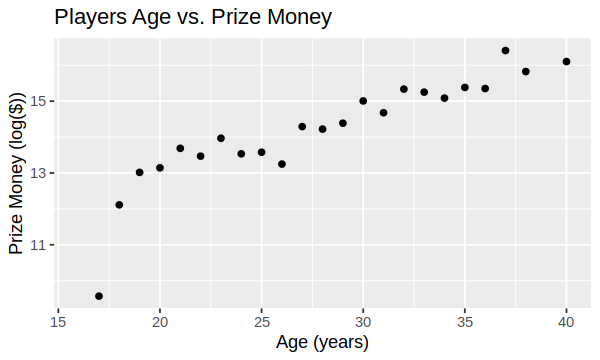

In [15]:
tennis_plot <- tennis_training |> group_by(age) |> summarise(prize_money = mean(prize_money, na.rm=TRUE)) |>
    ggplot(aes(x = age, y = log(prize_money))) + geom_point() + labs(x = "Age (years)", y = "Prize Money (log($))") + 
    ggtitle("Players Age vs. Prize Money")
tennis_plot
options(repr.plot.height=3, repr.plot.width=5)

In [ ]:
options(repr.plot.width=9, repr.plot.height=9)
tennis_pairplot <- tennis_training |> 
    ggpairs(
        lower = list(continuous = wrap('points', alpha = 0.4)),
        diag = list(continuous = "barDiag")
    ) +
    theme(text = element_text(size = 20))
credit_pairplot

### Methods

In [ ]:
#describe in written English the methods you used to perform your analysis from beginning to end that narrates the code the does the analysis.

### Results

In [ ]:
#state results

### Discussion

In [ ]:
#summarize what you found, discuss whether this is what you expected to find?, discuss what impact could such findings have? discuss what future questions could this lead to?

### References

In [ ]:
#At least 2 citations of literature relevant to the project (format is your choice, just be consistent across the references)., Make sure to cite the source of your data as well.